✅ Loaded matrix: 36753 genes x 800 cells


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.3979”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  3.9358e-15”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


✅ Output salvati in:  /home/jovyan/work/Results/script2 


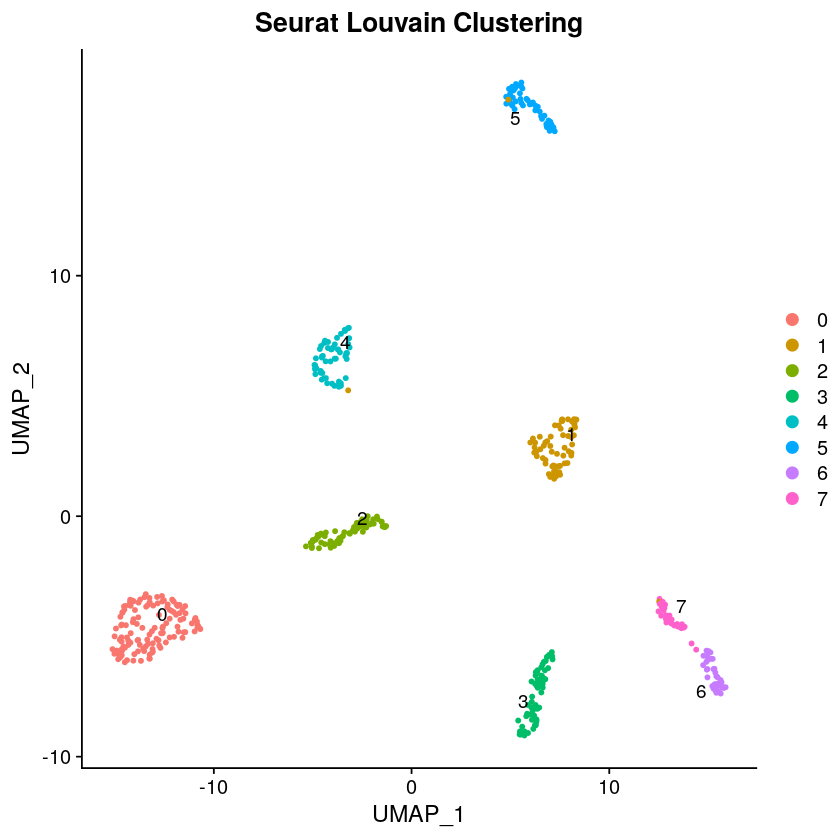

In [1]:
# ================== SCRIPT 2 — Seurat base (subset + UMAP) ==================
suppressPackageStartupMessages({
  library(Seurat)
  library(Matrix)
  library(ggplot2)
})

# ---------- PATHS ----------
base_dir    <- "/home/jovyan/work"
data_dir    <- file.path(base_dir, "Data")
results_dir <- file.path(base_dir, "Results", "script2")
dir.create(results_dir, showWarnings = FALSE, recursive = TRUE)

matrix_file   <- file.path(data_dir, "matrix.mtx.gz")
features_file <- file.path(data_dir, "features.tsv.gz")  # 10x: col1=gene_id
barcodes_file <- file.path(data_dir, "barcodes.tsv.gz")  # 10x: col1=barcode

# ---------- LOAD 10X ----------
mat <- readMM(matrix_file)

# prendi SOLO la prima colonna da features/barcodes
genes_df    <- read.delim(features_file, header = FALSE, stringsAsFactors = FALSE)
barcodes_df <- read.delim(barcodes_file, header = FALSE, stringsAsFactors = FALSE)
genes    <- genes_df[[1]]
barcodes <- barcodes_df[[1]]

stopifnot(nrow(mat) == length(genes))
stopifnot(ncol(mat) == length(barcodes))

rownames(mat) <- genes
colnames(mat) <- barcodes

cat(sprintf("✅ Loaded matrix: %d genes x %d cells\n", nrow(mat), ncol(mat)))

# ---------- SUBSAMPLE (opzionale) ----------
set.seed(42)
if (ncol(mat) > 500) {
  selected_cells <- sample(colnames(mat), 500)
  mat <- mat[, selected_cells, drop = FALSE]
}

# ---------- SEURAT PIPELINE ----------
seurat_obj <- CreateSeuratObject(counts = mat, project = "script2")

seurat_obj <- NormalizeData(seurat_obj, verbose = FALSE)
seurat_obj <- FindVariableFeatures(seurat_obj, verbose = FALSE)
seurat_obj <- ScaleData(seurat_obj, verbose = FALSE)
seurat_obj <- RunPCA(seurat_obj, verbose = FALSE)

seurat_obj <- FindNeighbors(seurat_obj, dims = 1:10, verbose = FALSE)
seurat_obj <- FindClusters(seurat_obj, resolution = 0.5, verbose = FALSE)

seurat_obj <- RunUMAP(seurat_obj, dims = 1:10, seed.use = 42, verbose = FALSE)

# ---------- PLOT UMAP (robusto) ----------
save_plot_safe <- function(p, file, width=8, height=6, dpi=300){
  ok <- tryCatch({
    ggplot2::ggsave(filename = file, plot = p, width = width, height = height, dpi = dpi, device = "png")
    TRUE
  }, error = function(e) FALSE)
  if(!ok){ png(file, width = width*300, height = height*300, res = dpi); print(p); dev.off() }
}

# evita patchwork: combine=FALSE -> ggplot puro
p_list <- DimPlot(seurat_obj, reduction = "umap", group.by = "seurat_clusters",
                  label = TRUE, repel = TRUE, combine = FALSE)
p <- p_list[[1]] + ggtitle("Seurat Louvain Clustering") + theme(legend.position = "right")

print(p)  # per notebook

# ---------- SAVE OUTPUTS ----------
save_plot_safe(p, file.path(results_dir, "umap_clusters.png"))
saveRDS(seurat_obj, file.path(results_dir, "seurat_obj_script2.rds"))

umap <- Embeddings(seurat_obj, "umap")
meta <- cbind(cell=rownames(seurat_obj@meta.data), seurat_obj@meta.data, umap)
write.csv(meta, file.path(results_dir, "metadata_with_umap.csv"), row.names = FALSE)

cat("✅ Output salvati in: ", results_dir, "\n")


In [2]:
# ======== SCRIPT 2 (parte 2) — Esporta cluster + UMAP ========
base_dir    <- "/home/jovyan/work"
results_dir <- file.path(base_dir, "Results", "script2")
dir.create(results_dir, showWarnings = FALSE, recursive = TRUE)

# controlli minimi
stopifnot(exists("seurat_obj"))
stopifnot("umap" %in% names(seurat_obj@reductions))

# estrazione
cell_ids <- colnames(seurat_obj)
clusters <- as.character(Idents(seurat_obj))
umap     <- Embeddings(seurat_obj, "umap")

# data frame unico
df <- data.frame(
  cell    = cell_ids,
  cluster = clusters,
  UMAP_1  = umap[, 1],
  UMAP_2  = umap[, 2],
  row.names = NULL
)

# salvataggio
out_csv <- file.path(results_dir, "seurat_clusters_umap.csv")
write.csv(df, out_csv, row.names = FALSE)

cat("✅ CSV salvato in: ", out_csv, "\n")


✅ CSV salvato in:  /home/jovyan/work/Results/script2/seurat_clusters_umap.csv 


In [3]:
df

cell,cluster,UMAP_1,UMAP_2
<chr>,<chr>,<dbl>,<dbl>
TAACGACAGATTGAGT-1_HTB178_HTB178-HTB178,1,7.177334,2.1089055
AGTAGCTCAGTGTGGA-1_DV90-DV90,4,-3.674946,5.5970413
GACCTTCTCACAGTGT-1_CCL-185-IG-CCL-185-IG,0,-14.669492,-5.0354131
TACACCCTCGCTGTCT-1_A549-A549,0,-14.615447,-4.0074342
CAGGTATGTGGCTAGA-1_CRL5868-CRL5868,7,13.004762,-4.3113661
CTTCGGTCACAAATGA-1_CCL-185-IG-CCL-185-IG,0,-13.524626,-5.6098431
CCTCAACTCCTCAGAA-1_PBMC-PBMCs,2,-4.582136,-0.7240651
CTCCCAAAGCCAGAGT-1_A549-A549,0,-12.867907,-3.3581366
CAACCAAAGACCATGG-1_CCL-185-IG-CCL-185-IG,0,-12.571991,-4.5925377


✅ UMAP plot salvato in:  /home/jovyan/work/Results/script2/umap_clusters_from_csv.png 


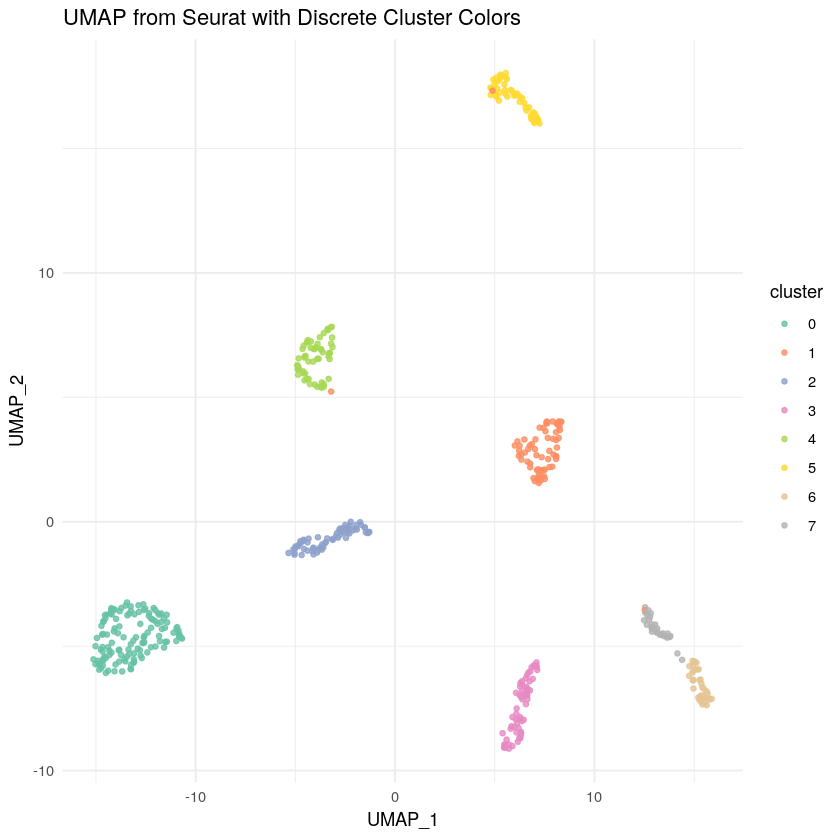

In [4]:
# ======== SCRIPT 2 (parte 3) — Plot UMAP da CSV ========
suppressPackageStartupMessages(library(ggplot2))

base_dir    <- "/home/jovyan/work"
results_dir <- file.path(base_dir, "Results", "script2")
dir.create(results_dir, showWarnings = FALSE, recursive = TRUE)

# carica il CSV esportato nella parte 2
df <- read.csv(file.path(results_dir, "seurat_clusters_umap.csv"))

# cluster come fattore
df$cluster <- as.factor(df$cluster)

# plot UMAP
p <- ggplot(df, aes(x = UMAP_1, y = UMAP_2, color = cluster)) +
  geom_point(alpha = 0.8, size = 1.2) +
  theme_minimal() +
  scale_color_brewer(palette = "Set2") +
  ggtitle("UMAP from Seurat with Discrete Cluster Colors")

print(p)

# salva
out_png <- file.path(results_dir, "umap_clusters_from_csv.png")
ggsave(out_png, plot = p, width = 8, height = 6, dpi = 300)

cat("✅ UMAP plot salvato in: ", out_png, "\n")
